<p style="font-family:Roboto; font-size: 28px; color: magenta"> Python for NLP: Multi-label Text Classification with Keras</p>

In [51]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
'''
 Multi-label text classification is one of the most common text classification problems.
'''

'\n Multi-label text classification is one of the most common text classification problems.\n'

In [2]:
'''The dataset contains comments from Wikipedia's talk page edits.
There are six output labels for each comment: toxic, severe_toxic, obscene, threat, insult and identity_hate.
A comment can belong to all of these categories or a subset of these categories,
    which makes it a multi-label classification problem
The dataset for this article can be downloaded from this Kaggle link.
We will only use the train.csv file that contains 160,000 records
'''

"The dataset contains comments from Wikipedia's talk page edits.\nThere are six output labels for each comment: toxic, severe_toxic, obscene, threat, insult and identity_hate.\nA comment can belong to all of these categories or a subset of these categories,\n    which makes it a multi-label classification problem\nThe dataset for this article can be downloaded from this Kaggle link.\nWe will only use the train.csv file that contains 160,000 records\n"

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _ImportingLibraries</p>

In [3]:
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate

import pandas as pd
import numpy as np
import re

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Importing and Analyzing the Dataset</p>

In [4]:
toxic_comments = pd.read_csv("./data/toxic_comments.csv")

In [5]:
toxic_comments.shape

(159571, 8)

In [6]:
toxic_comments.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Data preprocessing</p>

In [7]:
'''Let's remove all the records where any row contains a null value or empty string.'''
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [8]:
'''Let's randomly choose a comment_text column'''
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [9]:
'''This is clearly a toxic comment. Let's see the associated labels with this commen'''
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [10]:
'''Let's now plot the comment count for each label. To do so, we will first filter all the label or output columns.'''
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head(3)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0


<Axes: >

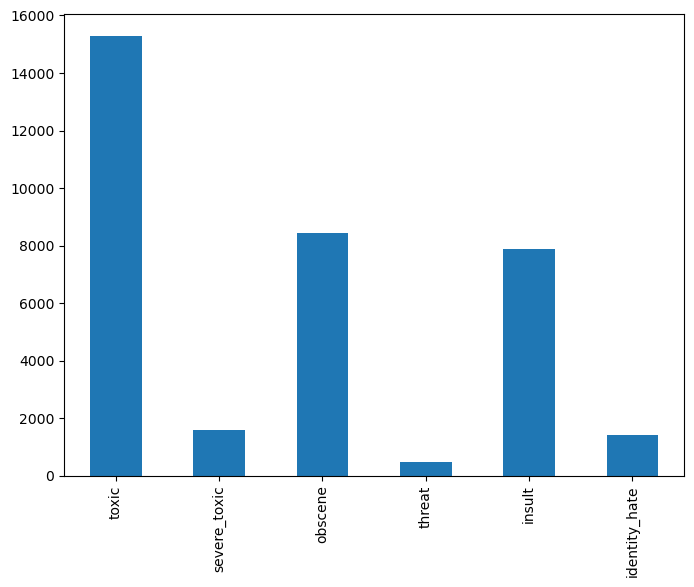

In [11]:
import matplotlib.pyplot as plt

'''Using the toxic_comments_labels dataframe,
we will plot bar plots that show the total comment counts for different labels'''
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

<p style="font-family:consolas; font-size: 24px; color: magenta"> 1.Multi-label Text Classification Model with Single Output Layer</p>

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Data preprocessing</p>

In [63]:
'''The first step is to define a function that cleans the textual data.'''
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [64]:
'''The text reviews will be cleaned using the preprocess_text function,
which removes punctuations and numbers from the text.'''
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [65]:
'''In the next step, we will divide our data into training and test sets:'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [66]:
'''The first step in word embeddings is to convert the words into their corresponding numeric indexes.
        To do so, we can use the Tokenizer class from the tensorflow.keras.preprocessing.text module.
'''
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
'''We will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings
and create a dictionary
that will contain words as keys and their corresponding embedding list as values'''

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('./data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [68]:
'''Finally, we will create an embedding matrix where rows will be equal to the number of words in the vocabulary (plus 1).
The number of columns will be 100 since each word in the GloVe word embeddings that
we loaded is represented as a 100 dimensional vector.'''
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Using Keras' functional API to create our model</p>

In [69]:
'''Our model will have one input layer, one embedding layer, one LSTM layer with 128 neurons
and one output layer with 6 neurons since we have 6 labels in the output'''
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [70]:
print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 200, 100)       │    14,824,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,942,322 (57.00 MB)

 Trainable params: 118,022 (461.02 KB)

 Non-trainable params: 14,824,300 (56.55 MB)

None


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [71]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - acc: 0.8795 - loss: 0.1812 - val_acc: 0.9895 - val_loss: 0.1410
Epoch 2/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - acc: 0.9831 - loss: 0.1109 - val_acc: 0.9941 - val_loss: 0.0751
Epoch 3/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - acc: 0.9939 - loss: 0.0694 - val_acc: 0.9943 - val_loss: 0.0617
Epoch 4/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - acc: 0.9944 - loss: 0.0600 - val_acc: 0.9943 - val_loss: 0.0587
Epoch 5/5
798/798 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - acc: 0.9928 - loss: 0.0654 - val_acc: 0.9940 - val_loss: 0.0645


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [72]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - acc: 0.9943 - loss: 0.0616
Test Score: 0.06315422803163528
Test Accuracy: 0.993984043598175


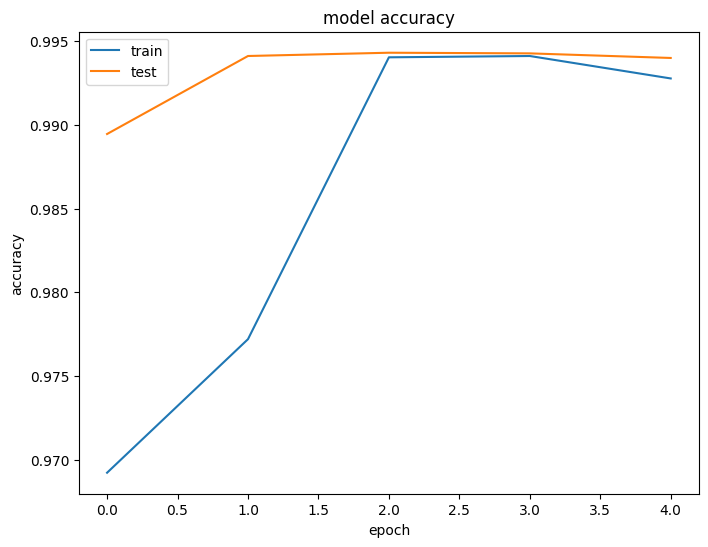

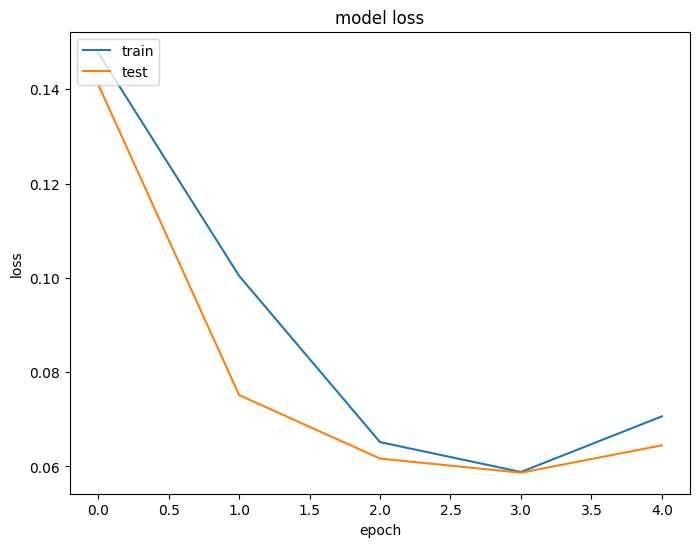

In [73]:
'''Finally, let's plot the values for loss and accuracy for both training and testing sets:'''
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

<p style="font-family:consolas; font-size: 24px; color: magenta"> 2.Multi-label Text Classification Model with Multiple Output Layers - activation='sigmoid'</p>

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Data preprocessing</p>

In [12]:
'''Let's first define our preprocessing function:'''
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [13]:
'''The second step is to create inputs and output for the model. '''

'''The input to the model will be the text comments, whereas the output will be six labels. '''
# creates the input layer
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))
# he combined output layer
y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [14]:
'''Let's divide the data into training and testing sets:'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
'''We will create 6 variables that store individual labels from the training data
and 6 variables that store individual label values for the test data.'''
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

In [15]:
'''The next step is to convert textual inputs to embedded vectors.'''
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
'''Here again we will use the GloVe word embeddings:'''
glove_file = open('./data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Create our model</p>

In [19]:
'''Our model will have one input layer, one embedding layer followed by one LSTM layer with 128 neurons.
The output from the LSTM layer will be used as the input to the 6 dense output layers.
Each output layer will have 1 neuron with sigmoid activation function.
Each output will predict integer value between 1 and 0 for the corresponding label.'''
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid', name='output1')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid', name='output2')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid', name='output3')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid', name='output4')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid', name='output5')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid', name='output6')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])

model.compile(optimizer='adam', loss={'output1':'mse', 'output2':'mse','output3':'mse','output4':'mse','output5':'mse','output6':'mse'},
              metrics={'output1':'accuracy', 'output2':'accuracy','output3':'accuracy','output4':'accuracy','output5':'accuracy','output6':'accuracy'})

In [20]:
'''
Model Outputs: If your model has multiple outputs, each output must have a unique name.
These names are used to map metrics, loss functions, and other configurations.
Metrics Key: The key in the metrics dictionary must correspond to the name of one of the model's outputs.
If it doesn't, TensorFlow/Keras raises this error.
'''
'''
1. Check Model Output Names
2. Update the metrics Dictionary
If the output names differ, update the metrics dictionary to match the output names:
'''
print(model.output_names)

ListWrapper(['output1', 'output2', 'output3', 'output4', 'output5', 'output6'])


In [21]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 100)  │ 14,824,300 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    117,248 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output3 (Dense)     │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output4 (Dense)     │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output5 (Dense)     │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output6 (Dense)     │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,942,322 (57.00 MB)

 Trainable params: 118,022 (461.02 KB)

 Non-trainable params: 14,824,300 (56.55 MB)

None


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [ ]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [ ]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()